---

# University of Liverpool

## COMP534 - Applied AI

---

This notebook is associated with Assignment 1. Use it to complete the assignment by following the instructions provided in each section, which includes a text cell describing the requirements. For additional details, see the Canvas.

In [137]:
# import libraries here
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
import statsmodels.api as sm

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split, learning_curve
from sklearn.preprocessing import FunctionTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor


# 1. **Data Management**


In this part, you need to:

1.   analyse and prepare the data. Use plots, graphs, and tables (such as histogram, box plots, scatterplots etc.) to better analyse the dataset and identify issues or potential improvements in the data, including (but not limited to) unnecessary feature/variable which can be dropped/removed, standardization, encoding, etc;
2.   split the data and define your experimental protocol (such as cross-validation or k-fold).

In [138]:
# First reaad in data set and assign valid parameter ranges based on the dataset description
df = pd.read_csv('data/assign1-grades.csv')

valid_school = ['GP', 'MS']
valid_sex = ['F', 'M']
valid_address = ['U', 'R']
valid_famsize = ['GT3', 'LE3']
valid_pstatus = ['T', 'A']
valid_reason = ['home', 'reputation', 'course', 'other']
valid_yes_no = ['yes', 'no']
valid_4scale = np.arange(5)
valid_5scale = np.arange(6)
valid_grade = np.arange(21)

minpass_grade = 12

# Ensure str columns are in the proper case 

upper_columns = ['school', 'sex', 'address', 'famsize', 'Pstatus']
lower_columns = ['reason', 'guardian', 'schoolsup', 'famsup', 'paid',
                 'activities', 'nursery', 'higher', 'internet', 'romantic']

for col in upper_columns:
    df[col] = df[col].str.upper()

for col in lower_columns:
    df[col] = df[col].str.lower()

# Remove null and invalid data 

df = df[df['school'].isin(valid_school)]
df = df[df['sex'].isin(valid_sex)]
df = df[df['address'].isin(valid_address)]
df = df[df['famsize'].isin(valid_famsize)]
df = df[df['Pstatus'].isin(valid_pstatus)]
df = df[df['reason'].isin(valid_reason)]
df = df[df['Grade'].isin(valid_grade)]

scale4 = ['Medu', 'Fedu', 'traveltime', 'studytime']
scale5 = ['famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']
yes_no = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
          'internet', 'romantic']

for col in scale4:
    df = df[df[col].isin(valid_4scale)]

for col in scale5:
    df = df[df[col].isin(valid_5scale)]

#print(df[yes_no])
#for col in yes_no:
#    df = df[df[col].isin(valid_yes_no)]

# Create the target column of pass/fail based on min Grade

df['result'] = np.where(df['Grade'] >= minpass_grade, 'pass', 'fail')


Now that the initial validation is complete we can analyse the data set and look for outliers and irrelevant columns

In [139]:
scaler = FunctionTransformer(np.log1p, validate=True)
df['absences'] = scaler.fit_transform(df[['absences']])

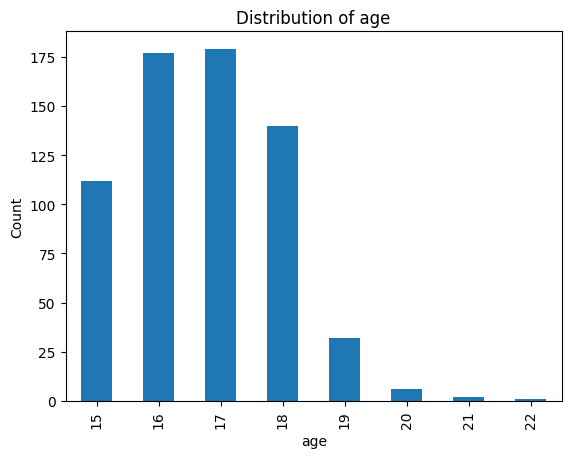

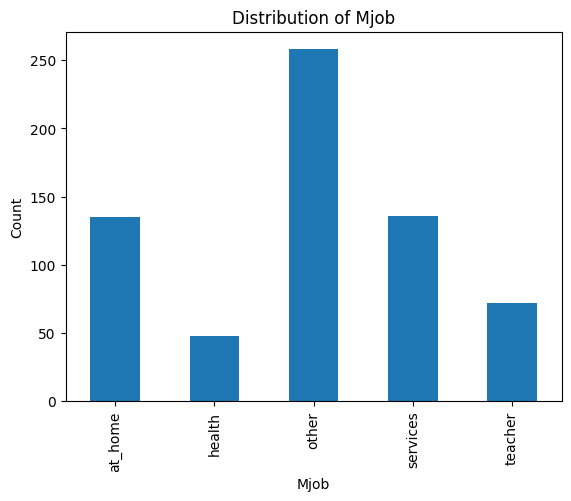

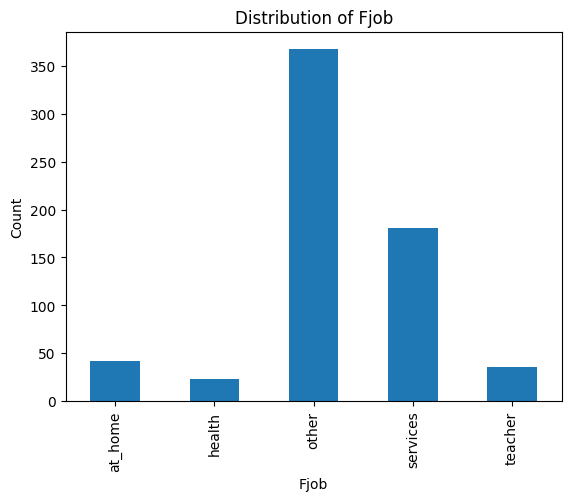

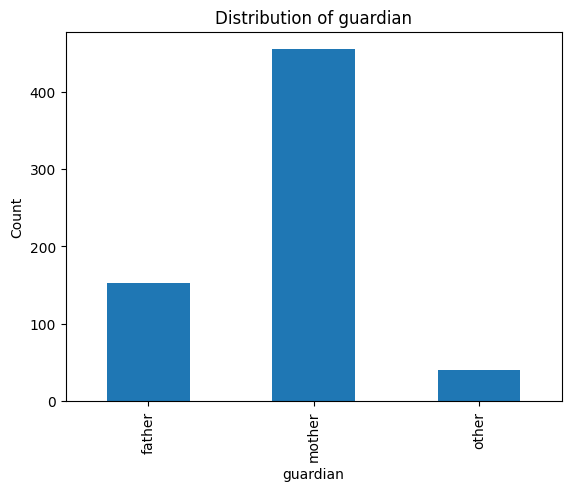

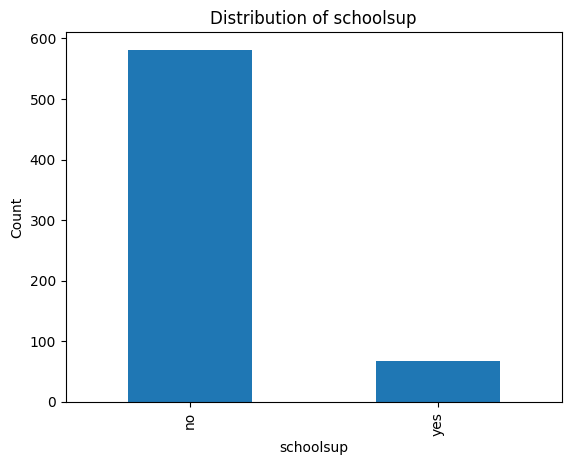

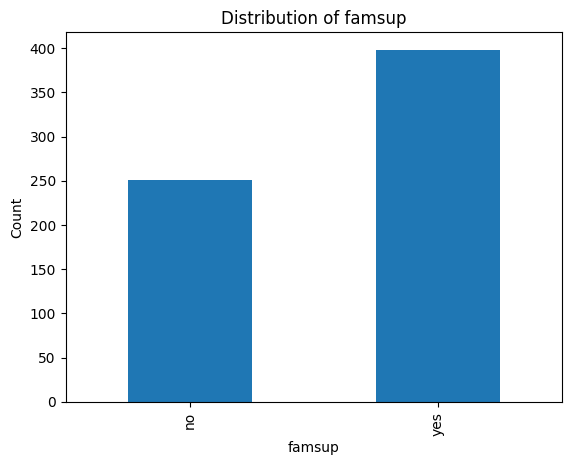

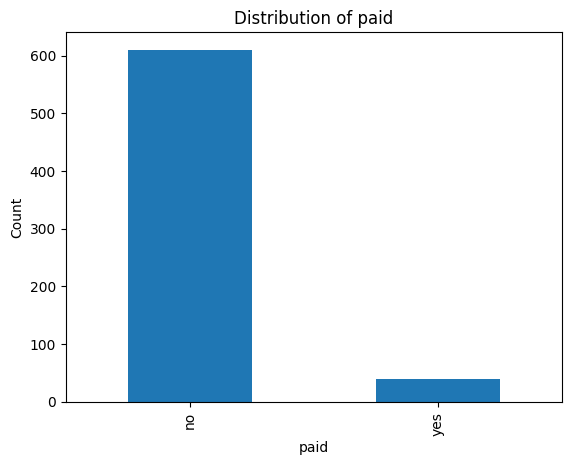

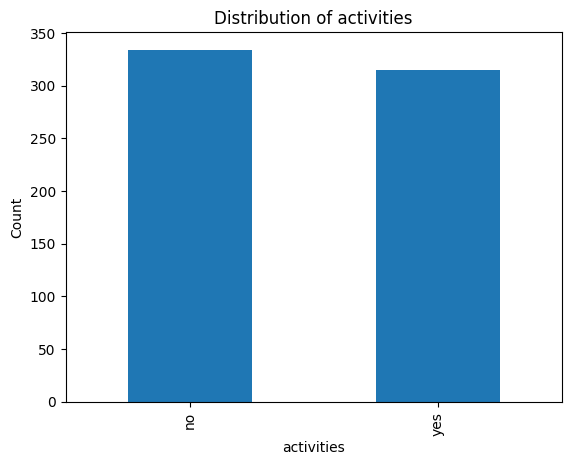

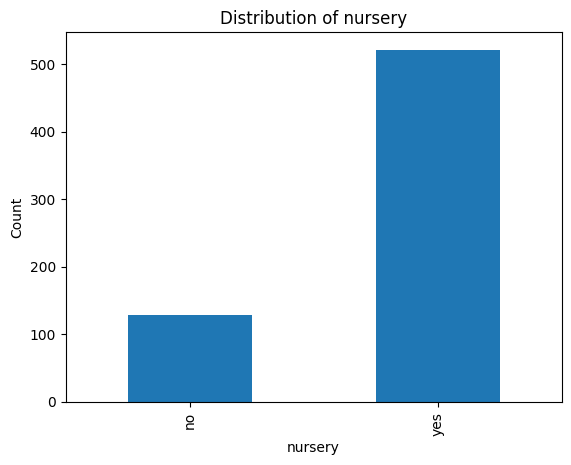

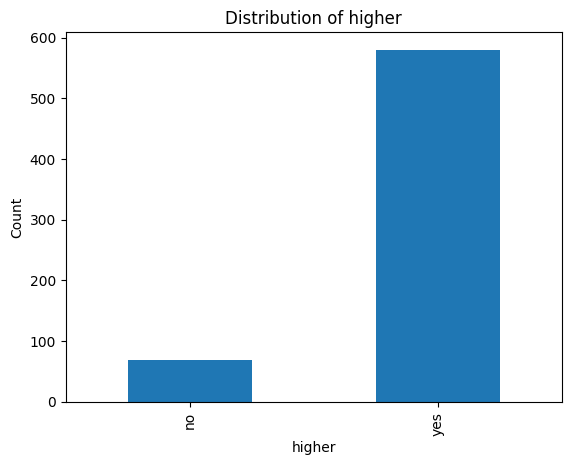

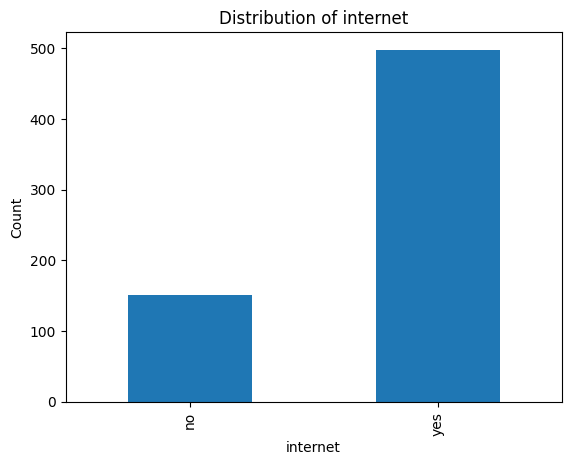

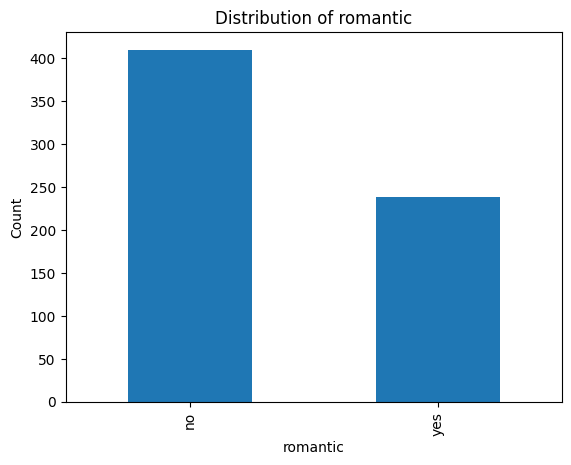

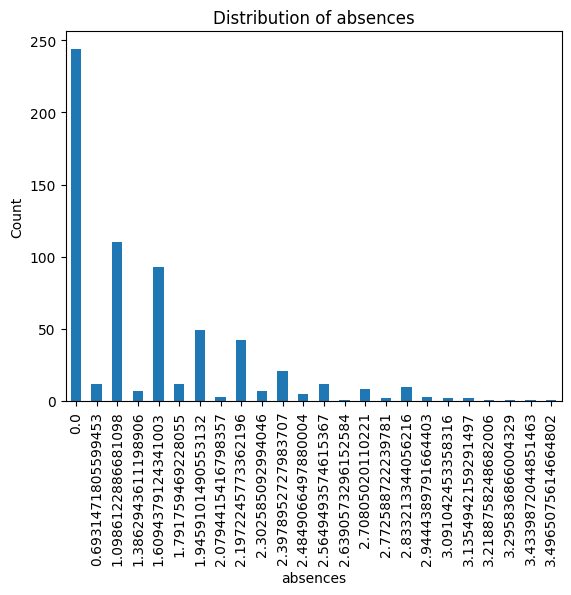

In [140]:
all_column = ['age', 'Mjob', 'Fjob', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'absences']
#all_column = df.columns.values()

# Give specific rows counts
for i in all_column:
    value_counts = df[i].value_counts().sort_index()
    #print(value_counts)

# Draw bar chart for each column
for column in all_column:
    data_counts = df[column].value_counts().sort_index()
    plt.figure()
    data_counts.plot(kind='bar')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'Distribution of {column}')
    plt.show()

In [141]:
# Remove outliers and unnecessary columns

df = df[df['age'] < 22]
df = df[df['absences'] < 22]
df = df.drop(columns=['paid', 'Grade'])

In [142]:
df_clean = df.drop(columns=["Unnamed: 0"], errors="ignore") # dropping the index column

boolean_columns = ["schoolsup", "famsup", "activities", "nursery", "higher", "internet", "romantic"]
df_clean[boolean_columns] = df_clean[boolean_columns].apply(lambda x: x.map({"yes": 1, "no":0})) #converting boolean data to numerical data representations

binary_columns = ["school", "sex", "address", "famsize", "Pstatus", "result"]
df_encoded = pd.get_dummies(df_clean, columns = binary_columns, drop_first= True ) #one-hot encoded (dummy) variables to handle categorical data

categorical_columns = ["Mjob", "Fjob", "reason", "guardian"]
df_encoded = pd.get_dummies(df_encoded, columns = categorical_columns, drop_first = False)

df_encoded = df_encoded[df_encoded.columns.drop(list(df_encoded.filter(regex='_other')))]

# Normalise absences
scaler = FunctionTransformer(np.log1p, validate=True)
df_encoded['absences'] = scaler.fit_transform(df_encoded[['absences']])


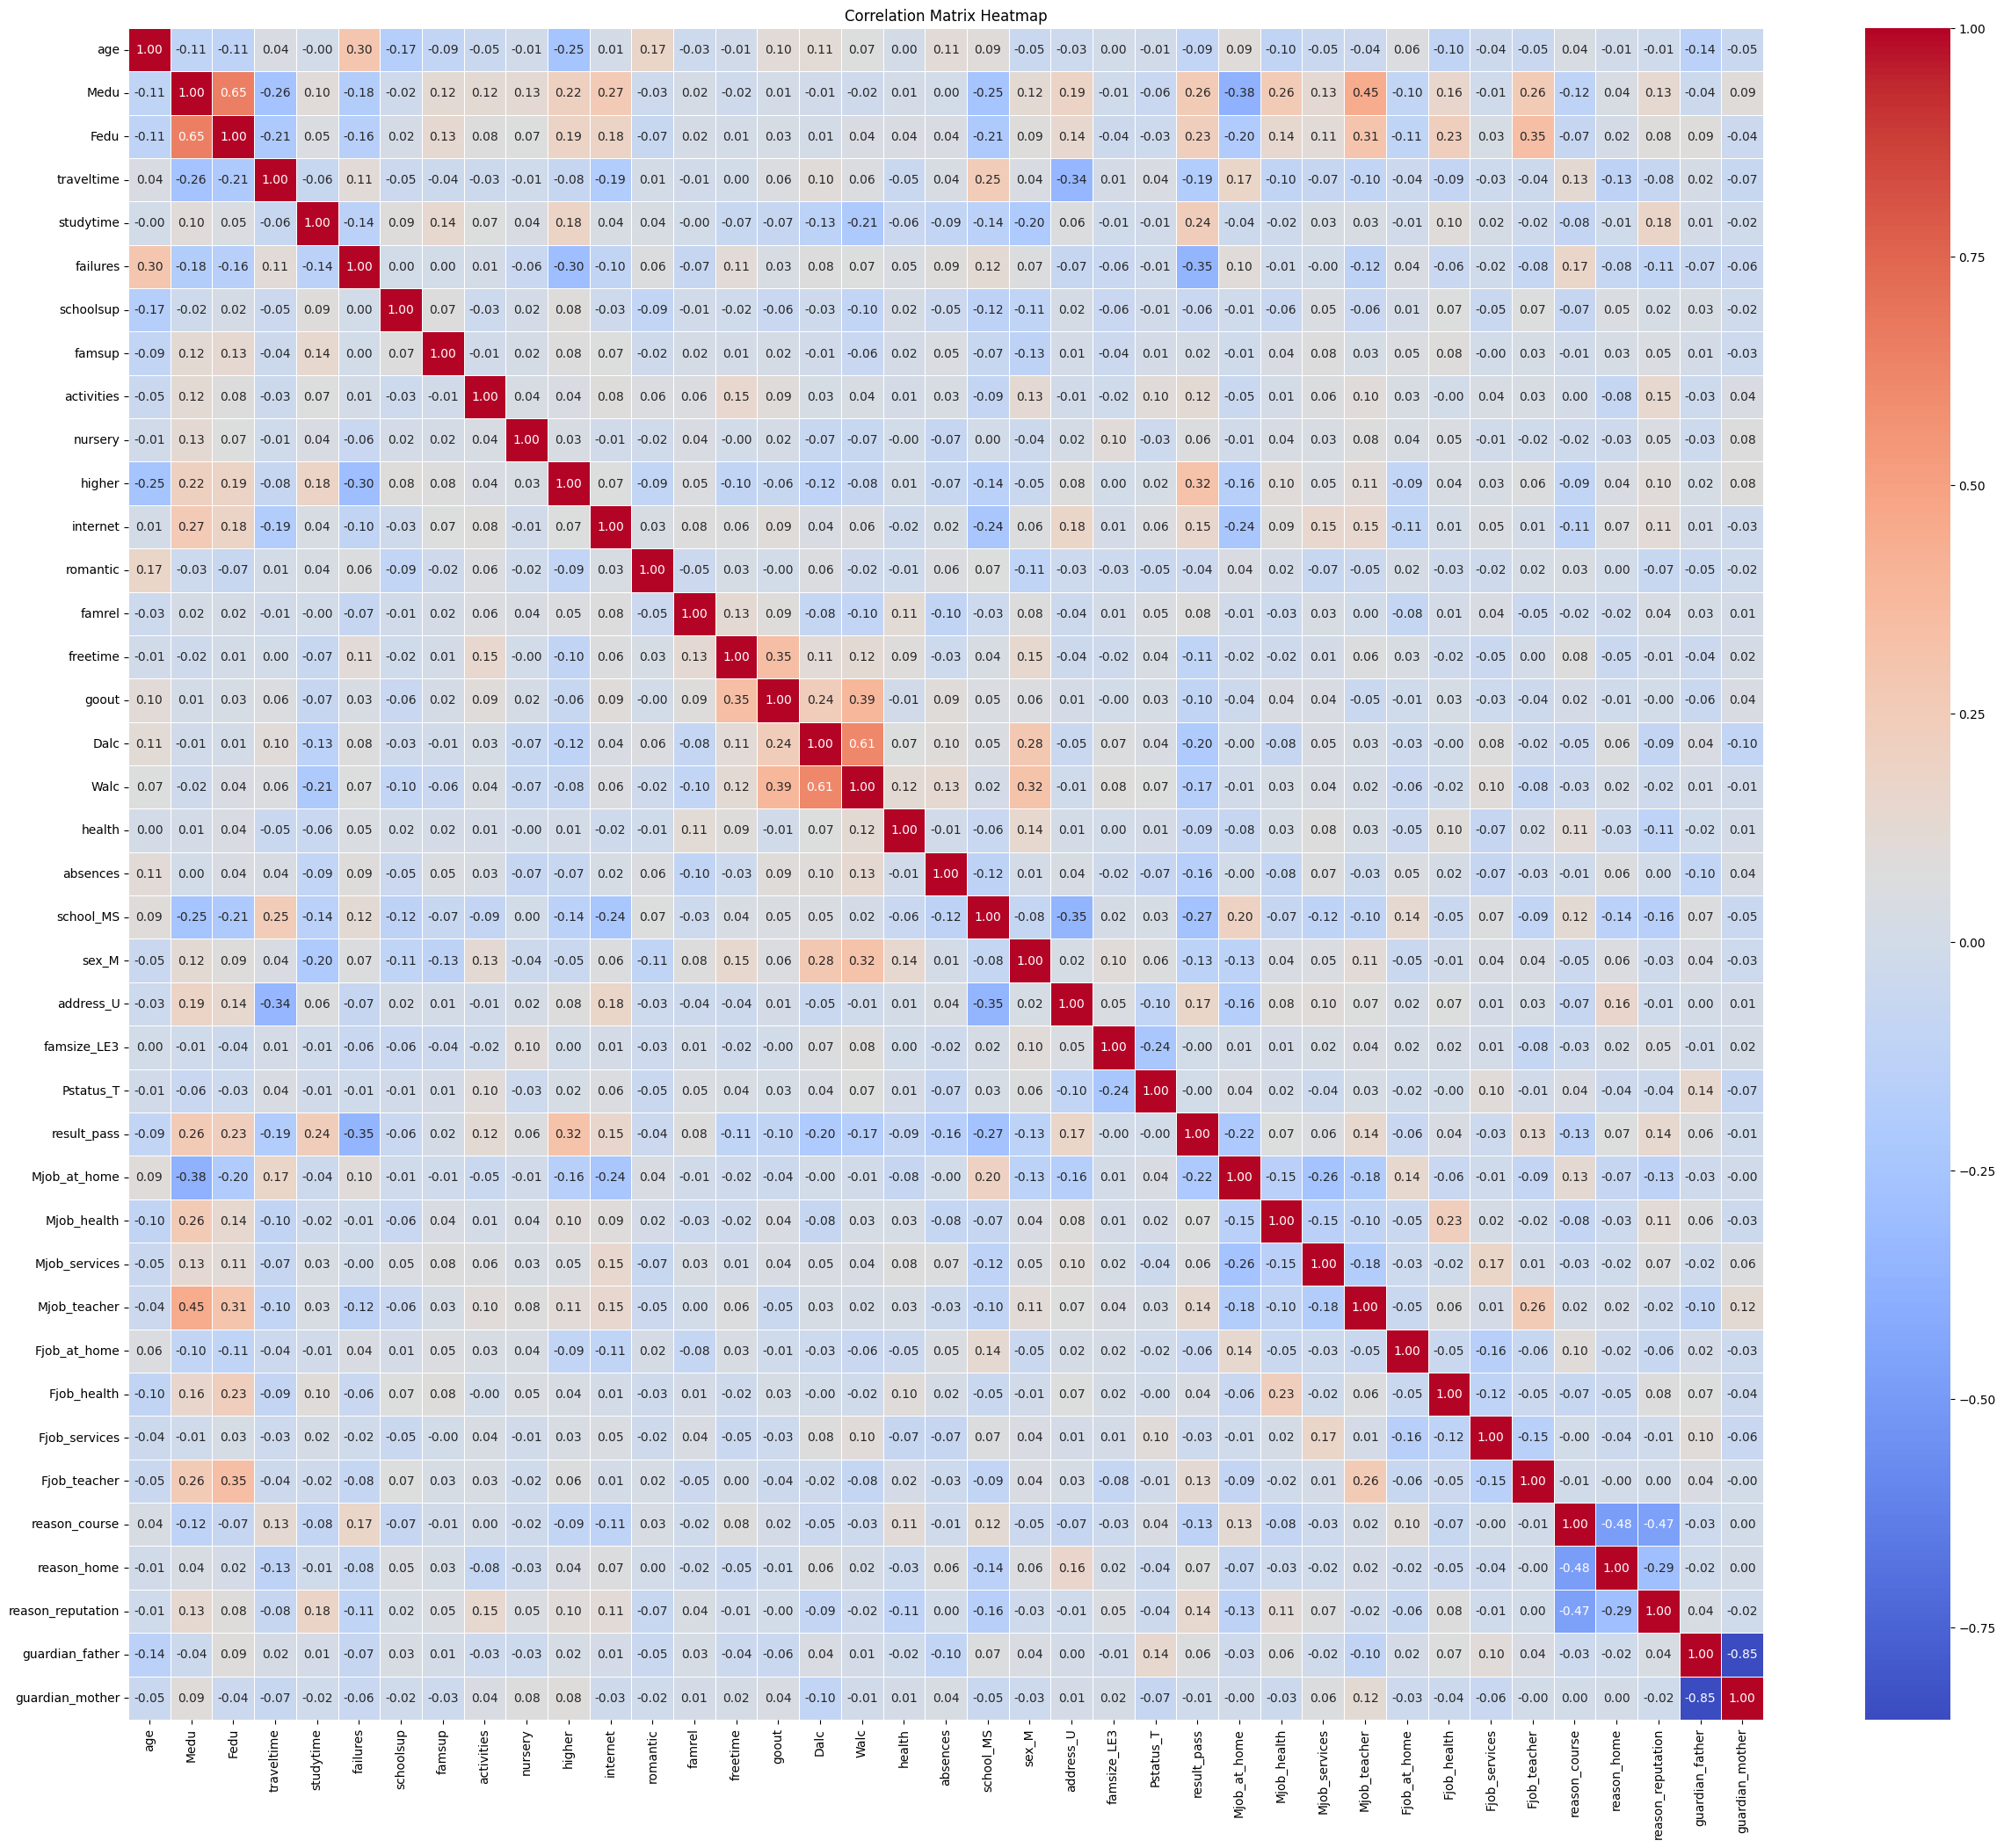

In [143]:
correlation_matrix = df_encoded.corr()
plt.figure(figsize=(30,25))
sns.heatmap (correlation_matrix, cmap= "coolwarm", annot = True, fmt= ".2f", linewidths= 0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [144]:
X = df_encoded.drop(columns=['result_pass']).astype(int)
X = sm.add_constant(X)  

y = df_encoded['result_pass']

# Logistic Regression
logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.468532
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            result_pass   No. Observations:                  648
Model:                          Logit   Df Residuals:                      609
Method:                           MLE   Df Model:                           38
Date:                Thu, 06 Mar 2025   Pseudo R-squ.:                  0.3214
Time:                        12:30:28   Log-Likelihood:                -303.61
converged:                       True   LL-Null:                       -447.38
Covariance Type:            nonrobust   LLR p-value:                 4.470e-40
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.8440      2.081     -1.367      0.172      -6.922       1.234
age     

In [145]:
# Drop columns based very low correlation and low significance 

df_encoded = df_encoded.drop(columns=['famsup', 'guardian_mother', 'guardian_father', 'Pstatus_T', 'famsize_LE3'])

In [146]:
vif_data = pd.DataFrame()
X = df_encoded.drop(columns=['result_pass']).astype(int)

vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

              Feature        VIF
0                 age  69.182812
1                Medu  15.388676
2                Fedu  10.997135
3          traveltime   6.659750
4           studytime   7.721743
5            failures   1.414939
6           schoolsup   1.223949
7          activities   2.175675
8             nursery   5.308302
9              higher  10.928227
10           internet   5.241863
11           romantic   1.741390
12             famrel  19.520143
13           freetime  12.385127
14              goout  12.043424
15               Dalc   6.446188
16               Walc   8.567944
17             health   7.907676
18           absences   1.561207
19          school_MS   2.182499
20              sex_M   2.250063
21          address_U   4.215234
22       Mjob_at_home   1.718634
23        Mjob_health   1.535729
24      Mjob_services   1.794120
25       Mjob_teacher   1.899720
26       Fjob_at_home   1.212816
27        Fjob_health   1.271290
28      Fjob_services   1.682522
29       F

In [147]:
# Remove columns 
# Note that Fedu and Medu are highligh related so we drop the one with lower correlation (Fedu)
# Similarly with Dalc and Walc we will drop Walc

df_encoded = df_encoded.drop(columns=['age', 'famrel', 'goout', 'freetime', 'Fedu', 'Walc'])

In [148]:
vif_data2 = pd.DataFrame()
X = df_encoded.drop(columns=['result_pass']).astype(int)
vif_data2["Feature"] = X.columns
vif_data2["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data2)

              Feature        VIF
0                Medu  10.308934
1          traveltime   5.845885
2           studytime   7.057036
3            failures   1.319677
4           schoolsup   1.216687
5          activities   2.123927
6             nursery   5.056706
7              higher  10.154666
8            internet   4.837647
9            romantic   1.693969
10               Dalc   4.176772
11             health   6.681631
12           absences   1.494668
13          school_MS   1.980955
14              sex_M   2.116571
15          address_U   3.917252
16       Mjob_at_home   1.628820
17        Mjob_health   1.500117
18      Mjob_services   1.781542
19       Mjob_teacher   1.830069
20       Fjob_at_home   1.199722
21        Fjob_health   1.201908
22      Fjob_services   1.627275
23       Fjob_teacher   1.256646
24      reason_course   4.672738
25        reason_home   2.991391
26  reason_reputation   3.039217


In [149]:
# Split the data using the 5-fold method 
kfold = KFold(5, shuffle=True, random_state=42)

y = df_encoded['result_pass']
X = df_encoded.drop(columns=['result_pass'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


---

# 2. **Model Training**

Here, you need to:

1.	select and compare at least three machine learning models (seen/discussed during the lectures) appropriate for your modelling;
2.	if there are hyperparameters in a selected algorithm, define a hyperparameter search protocol (you can define your own), and tune them.


In [150]:
# Implementation of SVM model

# Define our classifier
classifier = svm.SVC()

# Define hyperparameter grid
param_grid = [
    {'kernel': ['linear'], 'C': [0.1, 1, 10]},
    {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']},
    {'kernel': ['poly'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
     'degree': [2, 3, 4]}]

# Set up grid search to find the best hyperparams
grid_search = GridSearchCV(classifier, param_grid, cv=kfold,
                           scoring='accuracy', return_train_score=True)

print('Starting grid search to optimise hyperparams')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f'best hyperparameters: {best_params}')

best_svm = grid_search.best_estimator_

# Calculate accuracy scores
scores = cross_val_score(best_svm, X_train, y_train, cv=kfold, scoring='accuracy')

average_acc = np.mean(scores)

print(f"Accuracy Score for each fold: {[round(score, 4) for score in scores]}")
print(f"Average accuracy across 5 folds: {average_acc:.3f}")


# Print out scores for each param combo
accuracys = pd.DataFrame(grid_search.cv_results_)
#print(accuracys.columns)
accuracys = accuracys.sort_values('rank_test_score')
print(accuracys[['param_C', 'param_kernel', 'param_gamma', 'param_degree',
                'mean_train_score', 'mean_test_score']])


Starting grid search to optimise hyperparams
best hyperparameters: {'C': 1, 'kernel': 'linear'}
Accuracy Score for each fold: [0.7212, 0.7596, 0.7885, 0.7087, 0.7767]
Average accuracy across 5 folds: 0.751
    param_C param_kernel param_gamma  param_degree  mean_train_score  \
1       1.0       linear         NaN           NaN          0.784747   
7      10.0          rbf       scale           NaN          0.880311   
8      10.0          rbf        auto           NaN          0.881275   
21     10.0         poly       scale           2.0          0.847486   
5       1.0          rbf       scale           NaN          0.787647   
6       1.0          rbf        auto           NaN          0.788129   
22     10.0         poly        auto           2.0          0.849419   
2      10.0       linear         NaN           NaN          0.782810   
17      1.0         poly       scale           3.0          0.811288   
15      1.0         poly       scale           2.0          0.784269   
18

In [ ]:
# Implementation of RandomForest Model

# Define the parameter grid for tuning
param_grid = {
    "n_estimators": [100, 150, 200],          # Number of trees
    "max_depth": [10, 20, 30],              # Tree depth limit
    "min_samples_split": [3, 5, 10],          # Minimum samples to split a node
    "min_samples_leaf": [4, 6, 8],            # Minimum samples per leaf
    "max_features": ["sqrt", "log2"]          # Features considered per split
}

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(rf_model, param_grid, cv=kfold, scoring="accuracy", return_train_score=True)
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_rf = grid_search.best_estimator_

print("Best Hyperparameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)

# Print out scores for each param combo
accuracys = pd.DataFrame(grid_search.cv_results_)

accuracys = accuracys.sort_values('rank_test_score')
print(accuracys[['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features',
                'mean_train_score', 'mean_test_score']])

In [ ]:
# Implementation of Logistic Regression Model

param_grid = {
    'penalty': ['l1', 'l2'],                    #l1 (Lasso), l2 (Ridge)
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [10000]
}

best_params = None
best_score = 0
accuracies = []
conf_matrices = []
class_reports = []

for train_index, val_index in kfold.split(X_train, y_train):
    
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    
    model = LogisticRegression()
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='accuracy'
    )
    
    grid_search.fit(X_train, y_train)

    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_params = grid_search.best_params_

    best_logistic_model = grid_search.best_estimator_
    best_logistic_model.fit(X_train, y_train)

    y_pred = best_logistic_model.predict(X_val)
    
    accuracies.append(accuracy_score(y_val, y_pred))
    conf_matrices.append(confusion_matrix(y_val, y_pred))
    class_reports.append(classification_report(y_val, y_pred, output_dict=True))

avg_accuracy = np.mean(accuracies)
avg_conf_matrix = np.mean(conf_matrices, axis=0)
avg_class_report = np.mean([report['accuracy'] for report in class_reports])

df_results = pd.DataFrame(grid_search.cv_results_)

top_10_results = df_results[['param_penalty', 'param_C', 'param_solver', 'param_max_iter', 
                             'mean_test_score', 'std_test_score', 'rank_test_score']]\
                    .sort_values(by='rank_test_score')\
                    .head(10)

print(f"Best Hyperparameters: {best_params}")
print(f"Best Training Accuracy: {best_score:.3f}")
print(f"Average Test Accuracy: {avg_accuracy:.3f}")
print("Average Confusion Matrix:\n", avg_conf_matrix)
print("Average Classification Report (accuracy): {:.3f}".format(avg_class_report))
print("\nTop 10 Hyperparameter Configurations:\n", top_10_results)



Best Hyperparameters: {'C': 0.1, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
Best Training Accuracy: 0.780
Average Test Accuracy: 0.761
Average Confusion Matrix:
 [[26.6 16.8]
 [ 8.  52.2]]
Average Classification Report (accuracy): 0.761

Top 10 Hyperparameter Configurations:
    param_penalty  param_C param_solver  param_max_iter  mean_test_score  \
10            l2     0.10    liblinear           10000         0.761446   
11            l2     0.10         saga           10000         0.759036   
12            l1     1.00    liblinear           10000         0.742169   
13            l1     1.00         saga           10000         0.742169   
14            l2     1.00    liblinear           10000         0.737349   
15            l2     1.00         saga           10000         0.737349   
17            l1    10.00         saga           10000         0.730120   
7             l2     0.01         saga           10000         0.727711   
8             l1     0.10    lib

---

# 3. **Evaluate models**

Here, you need to:

1.	test the model (the best one you obtained from the above stage) on the testing dataset.


Accuracy Score:
 0.8153846153846154
Confusion Matrix:



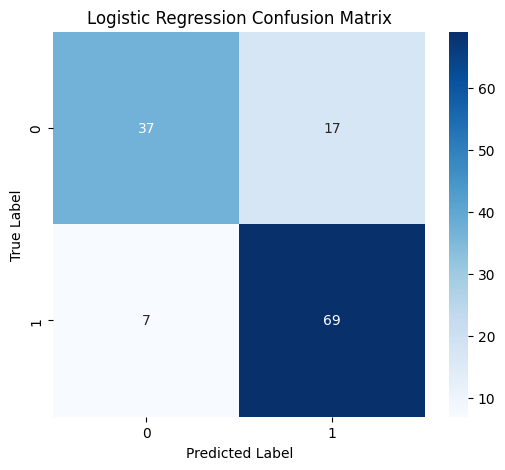

Classification Report:
               precision    recall  f1-score   support

       False       0.84      0.69      0.76        54
        True       0.80      0.91      0.85        76

    accuracy                           0.82       130
   macro avg       0.82      0.80      0.80       130
weighted avg       0.82      0.82      0.81       130



In [ ]:
# Assign our best model

best_model = best_logistic_model

# Compute the accuracy of our best model

y_pred = best_model.predict(X_test)
print("Accuracy Score:\n", accuracy_score(y_test, y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n")
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# Compute classification report
print("Classification Report:\n", classification_report(y_test, y_pred)) 
